In [3]:
from calibration import calibration
# libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta

import sys 
sys.path.append("../models/")
from Basin import Basin
from stochastic_SEIRD import simulate
from functions import compute_contacts, get_IFR_fixed, get_epi_params, wmape
from deaths import compute_deaths

from datetime import datetime

In [2]:
country = "Kyrgyzstan"
calibration(basin_name=country,
            nsim=101,
            step_save=100,
            R0min=0.6,
            R0max=2.0,
            Imultmin=1.,
            Imultmax=25.0,
            Rmultmin=1.0,
            Rmultmax=25.0,
            VOCdeltadays=30,
            starting_month=12,
            vaccine='age-order', 
            savefolder='posterior_samples_test')

0

In [4]:
file = os.listdir('./posterior_samples_test/posterior_samples_Kyrgyzstan')[0]
post = np.load(f"./posterior_samples_test/posterior_samples_Kyrgyzstan/{file}", allow_pickle=True)["arr_0"]
print(post.shape)

# get best run
params = post[np.argmin([p[-1] for p in post])]
print("best wMAPE: {0}".format(params[-1]))

(10100, 10)
best wMAPE: 0.5484707515092151


In [6]:
# ([R0, Delta, seasonality_min, psi, I_mult, R_mult, ifr_mult, scaler / 100.0, date_intro_VOC, err])
# simulation dates
start_date = datetime(2020, 12, 1)
end_date = datetime(2021, 12, 1)

# create Basin object
basin = Basin(country, "../basins/")
params = post[np.argmin([p[-1] for p in post])]

# get real deaths (first month excluded for the delay Delta)
real_deaths = basin.epi_data_deaths.loc[(basin.epi_data_deaths["date"] >= start_date) &
                                        (basin.epi_data_deaths["date"] < end_date)]["daily"][33:].reset_index(drop=True)

Cs, dates = compute_contacts(basin, start_date, end_date)


# simulate(basin, Cs, R0, Delta, dates, seasonality_min, vaccine, I_mult, R_mult, psi, basin.vaccinations, date_intro_VOC)
results = simulate(basin, Cs, params[0], params[1], 
                   dates, params[2], 'age-order', params[4],
                   params[5], params[3],
                   basin.vaccinations, 
                   params[8])



IFR = get_IFR_fixed('verity')
epi_params = get_epi_params()
epi_params["IFR"] = params[6]* IFR
epi_params["IFR_VOC"] = params[6] * IFR
epi_params["Delta"] = int(params[1])

results_deaths = compute_deaths(results["recovered"], results["recovered_VOC"], results["recovered_V1i"],
                                results["recovered_V2i"], results["recovered_V1i_VOC"], results["recovered_V2i_VOC"], epi_params)

df_deaths = pd.DataFrame(data={"real_deaths": real_deaths.values, "sim_deaths": params[7] * results_deaths["deaths_TOT"].sum(axis=0)[33:]}, index=dates[33:])
df_deaths = df_deaths.resample("W").sum()

wMAPE: 0.5729641105249009


<AxesSubplot:>

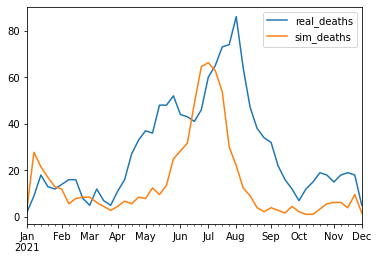

In [7]:
# R0, Delta, seasonality_min, psi, I_mult, R_mult, scaler, date_intro_VOC, err
print("wMAPE: {0}".format(wmape(df_deaths.real_deaths.values, df_deaths.sim_deaths.values)))
df_deaths.plot()